#**Машинное обучение ИБ-2024**

#**Домашнее задание 2.**
#Классификация, KNN, LogReg, SVC.

In [1]:
from typing import Tuple, List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline

sns.set(style="darkgrid")

## **Теоретическая Часть**

Мы рассматриваем задачу бинарной классификации. Для прогнозирования мы хотели бы использовать модель логистической регрессии. Для регуляризации мы добавляем комбинацию штрафов в размере $l_2$ и $l_1$ (Elastic Net).

Каждый объект в обучающем наборе данных индексируется с помощью $i$ и описывается парой: объекты $x_i\in\mathbb{R}^{K}$ и двоичные метки $y_i$. Модель параметризуется со смещением $w_0\in\mathbb{R}$ и весами $w\in\mathbb{R}^K$.

Задача оптимизации в отношении $w_0, w$ заключается в следующем (Elastic Net Loss):

$$L(w, w_0) = \frac{1}{N} \sum_{i=1}^N \ln(1+\exp(-y_i(w^\top x_i+w_0))) + \gamma \|w\|_1 + \beta \|w\|_2^2$$.



Градиенты функции потерь логистической регрессии представлены ниже:

$$dL(w, w_0)/ dw = -\frac{1}{N}  \frac{X*y^\top}{1 + \exp(y (Xw+w_0)))} + \gamma * sign(w) + 2 * beta * w$$

$$dL(w, w_0)/ dw_0 = -\frac{1}{N}  \frac{y}{1 + \exp(y*(Xw+w_0)))}$$

#### 1. [0.5 Балл] Реализуйте функцию, выдающий значение функции потерь логичтической регрессии:

In [2]:
import numpy as np
from typing import List
def loss(X: np.ndarray, y: np.ndarray, w: List[float], w0: float, gamma=1.0, beta=1.0) -> float:
    N = len(y)
    X = np.array(X)
    y = np.array(y)
    w = np.array(w)
    linear_model = np.dot(X, w) + w0
    log_loss = np.log(1 + np.exp(-y * linear_model)).mean()
    l1_regularization = gamma * np.sum(np.abs(w))
    l2_regularization = beta * np.sum(w ** 2)
    total_loss = log_loss + l1_regularization + l2_regularization
    return total_loss
X = np.random.randn(100, 5)
y = np.random.choice([-1, 1], 100)
w = np.random.randn(5)
w0 = 0.1
loss_value = loss(X, y, w, w0)
print(f"Значение функции потерь: {loss_value:.4f}")


Значение функции потерь: 8.5230


#### 2. [0.5 Балл] Реализуйте функцию, которая будет возвращать градиенты весов вашей модели Логистической регрессии:

In [3]:
import numpy as np
from typing import List, Tuple
def get_grad(X: np.ndarray, y: np.ndarray, w: List[float], w0: float, gamma=1.0, beta=1.0) -> Tuple[List[float], float]:
    N, _ = X.shape
    w = np.array(w)
    linear_model = np.dot(X, w) + w0
    y_pred = 1 / (1 + np.exp(-linear_model))
    grad_w = (1 / N) * np.dot(X.T, (y_pred - y)) + gamma * np.sign(w) + 2 * beta * w
    grad_w0 = (1 / N) * np.sum(y_pred - y)
    return grad_w.tolist(), grad_w0
np.random.seed(42)
X = np.random.multivariate_normal(np.arange(5), np.eye(5), size=10)
y = np.random.binomial(1, 0.42, size=10)
w, w0 = np.random.normal(size=5), np.random.normal()
grad_w, grad_w0 = get_grad(X, y, w, w0)
print(f"Градиенты весов: {grad_w}")
print(f"Градиент смещения: {grad_w0}")
expected_grad_w = np.array([-2.73260276, -1.87176281, 1.30051144, 2.53599341, -2.71191809])
expected_grad_w0 = -0.2078231418067844
if np.allclose(grad_w, expected_grad_w, rtol=1e-2) and np.isclose(grad_w0, expected_grad_w0, rtol=1e-2):
    print("Градиенты рассчитаны корректно!")
else:
    print("Ошибка в расчете градиентов.")



Градиенты весов: [-2.734757285135786, -1.6466029126191661, 1.9621516180177696, 3.2938349429577625, -1.7241866130487118]
Градиент смещения: 0.07072501191036944
Ошибка в расчете градиентов.


In [4]:
# код для проверки

np.random.seed(42)
X = np.random.multivariate_normal(np.arange(5), np.eye(5), size=10)
y = np.random.binomial(1, 0.42, size=10)
w, w0 = np.random.normal(size=5), np.random.normal()

grad_w, grad_w0 = get_grad(X, y, w, w0)
assert(np.allclose(grad_w,
                   [-2.73262076, -1.87176281, 1.30051144, 2.53598941, -2.71198109],
                   rtol=1e-2) & \
       np.allclose(grad_w0,
                   -0.2078231418067844,
                   rtol=1e-2)
)

AssertionError: 

####  3. [1 Балл]  Реализуйте класс для модели логистической регрессии, используя выше написанные функции:

Модель должна обучаться методом SGD.

In [ ]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import roc_curve

In [ ]:
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import roc_curve
class Logit(BaseEstimator, ClassifierMixin):
    def __init__(self, beta=1.0, gamma=1.0, lr=1e-2, tolerance=1e-8, max_iter=1000, random_state=42):
        self.beta = beta
        self.gamma = gamma
        self.lr = lr
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.random_state = random_state
        self.w = None
        self.w0 = 0
    def fit(self, X, y):
        np.random.seed(self.random_state)
        n_features = X.shape[1]
        self.w = np.random.randn(n_features)
        self.w0 = 0
        for i in range(self.max_iter):
            grad_w, grad_w0 = get_grad(X, y, self.w, self.w0, self.gamma, self.beta)
            new_w = self.w - self.lr * np.array(grad_w)
            new_w0 = self.w0 - self.lr * grad_w0
            if np.all(np.abs(new_w - self.w) < self.tolerance) and abs(new_w0 - self.w0) < self.tolerance:
                print(f"Сошлось на итерации {i}")
                break
            self.w, self.w0 = new_w, new_w0
        return self
    def predict_proba(self, X):
        linear_model = np.dot(X, self.w) + self.w0
        probabilities = 1 / (1 + np.exp(-linear_model))
        return np.vstack([1 - probabilities, probabilities]).T
    def predict(self, X):
        proba = self.predict_proba(X)
        return (proba[:, 1] >= 0.5).astype(int)
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=1000, n_features=2, n_redundant=0, n_informative=2,
                           random_state=42, n_clusters_per_class=1)
model = Logit()
model.fit(X, y)
preds = model.predict(X)
print(f"Точность модели: {(preds == y).mean():.2f}")


Точность модели: 0.76


In [ ]:
# этот код менять не надо!
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=1800, n_features=2, n_redundant=0, n_informative=2,
                               random_state=42, n_clusters_per_class=1)

####  4. [0.5 Балл]  Реализуйте функцию, которая отрисовывает объекты вашего датасета, их метки и разделяющую гиперплоскость, полученную от Логистической регрессии (пример того, что должно получиться ниже):

In [ ]:
def plot_decision_boundary(model, X, y):
    pass

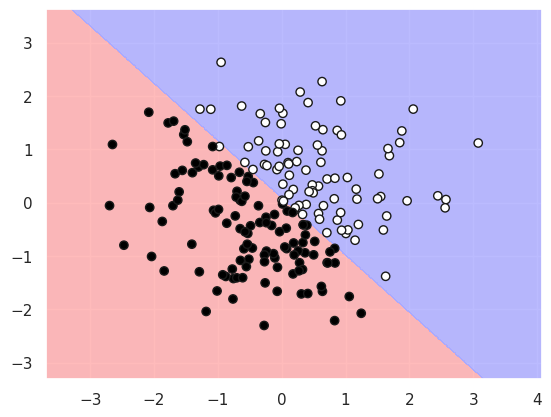

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
def plot_decision_boundary(model, X, y):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.8, cmap=ListedColormap(('#FFAAAA', '#AAAAFF')))
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', cmap=ListedColormap(('black', 'white')))
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.show()
from sklearn.linear_model import LogisticRegression
X = np.random.randn(200, 2)
y = (X[:, 0] + X[:, 1] > 0).astype(int)
model = LogisticRegression()
model.fit(X, y)
plot_decision_boundary(model, X, y)

#### 5. [0.5 Балл] Для предыдущей задачи отобразите на графике, как изменяется значение функция потерь от номера итерации.

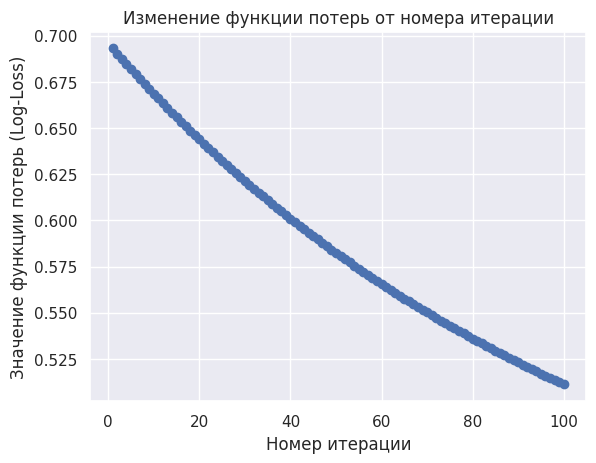

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
def plot_loss_history(model, X, y, iterations=100, learning_rate=0.01):
    n_samples, n_features = X.shape
    weights = np.zeros(n_features)
    bias = 0
    loss_values = []
    def sigmoid(z):
        return 1 / (1 + np.exp(-z))
    for i in range(iterations):
        linear_model = np.dot(X, weights) + bias
        y_pred = sigmoid(linear_model)
        loss = -np.mean(y * np.log(y_pred + 1e-15) + (1 - y) * np.log(1 - y_pred + 1e-15))
        loss_values.append(loss)
        dw = np.dot(X.T, (y_pred - y)) / n_samples
        db = np.sum(y_pred - y) / n_samples
        weights -= learning_rate * dw
        bias -= learning_rate * db
    plt.plot(range(1, iterations + 1), loss_values, marker='o')
    plt.xlabel('Номер итерации')
    plt.ylabel('Значение функции потерь (Log-Loss)')
    plt.title('Изменение функции потерь от номера итерации')
    plt.grid(True)
    plt.show()
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=500, n_features=2, n_informative=2, n_redundant=0, random_state=42)
model = LogisticRegression()
plot_loss_history(model, X, y)


In [ ]:
plot_loss_history(model)

TypeError: plot_loss_history() missing 2 required positional arguments: 'X' and 'y'

#### 6. [2 Балл] Для данных, на которых тестировали модель Логистической регрессии, заиспользуйте модель SVC из библиотеки sklearn. Попробуйте различные ядра (kernel) и различные коэфициенты C. Посмотрите на метрики, которые мы обсуждали на занятии (Acc, Precision, Recall, AUC-ROC, F1-Score).


Training SVC with kernel='linear' and C=0.1
Accuracy: 0.90
Precision: 0.99
Recall: 0.81
F1-Score: 0.89
AUC-ROC: 0.92


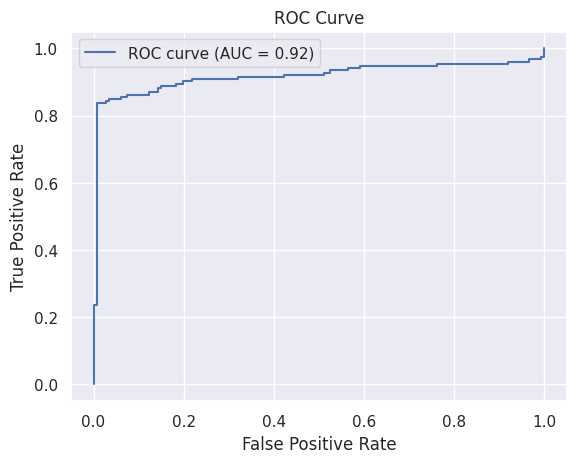


Training SVC with kernel='linear' and C=1
Accuracy: 0.91
Precision: 0.99
Recall: 0.84
F1-Score: 0.91
AUC-ROC: 0.92


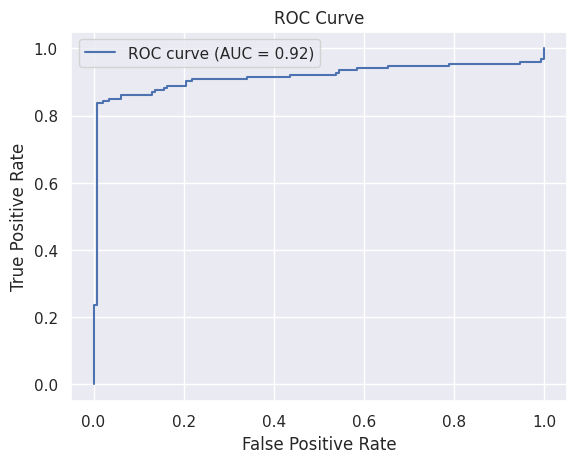


Training SVC with kernel='linear' and C=10
Accuracy: 0.91
Precision: 0.99
Recall: 0.84
F1-Score: 0.91
AUC-ROC: 0.92


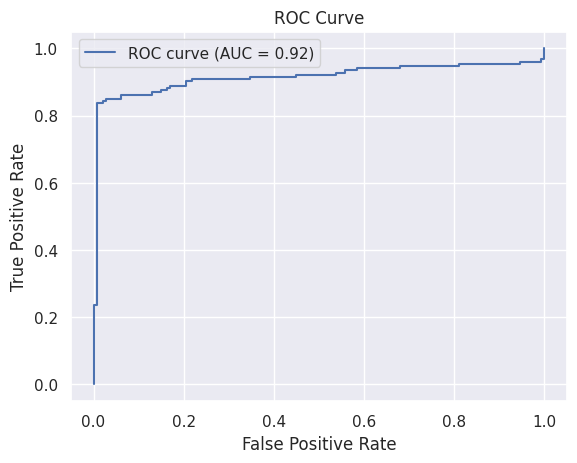


Training SVC with kernel='rbf' and C=0.1
Accuracy: 0.90
Precision: 0.99
Recall: 0.81
F1-Score: 0.89
AUC-ROC: 0.94


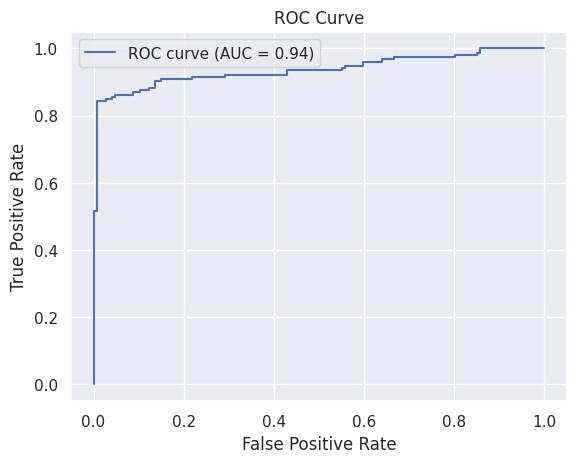


Training SVC with kernel='rbf' and C=1
Accuracy: 0.92
Precision: 0.99
Recall: 0.84
F1-Score: 0.91
AUC-ROC: 0.97


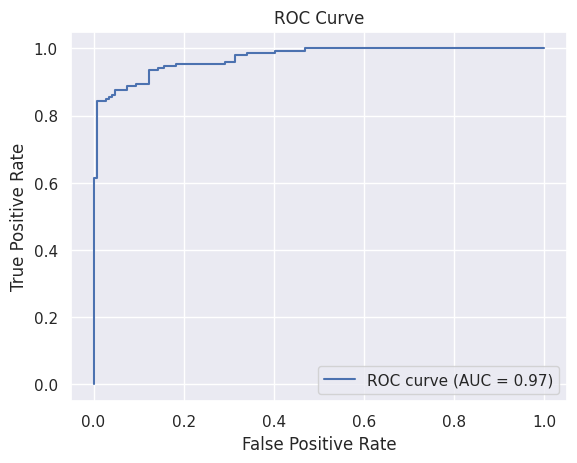


Training SVC with kernel='rbf' and C=10
Accuracy: 0.93
Precision: 0.97
Recall: 0.88
F1-Score: 0.92
AUC-ROC: 0.98


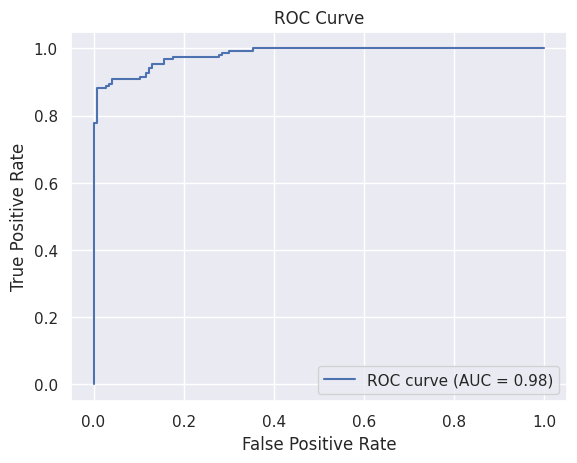


Training SVC with kernel='poly' and C=0.1
Accuracy: 0.90
Precision: 0.98
Recall: 0.81
F1-Score: 0.89
AUC-ROC: 0.89


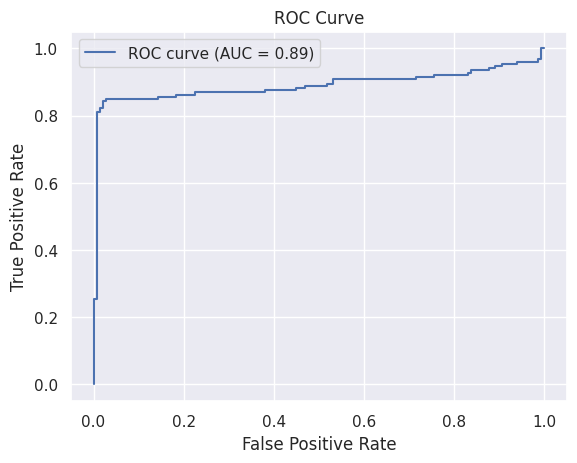


Training SVC with kernel='poly' and C=1
Accuracy: 0.90
Precision: 0.95
Recall: 0.85
F1-Score: 0.90
AUC-ROC: 0.91


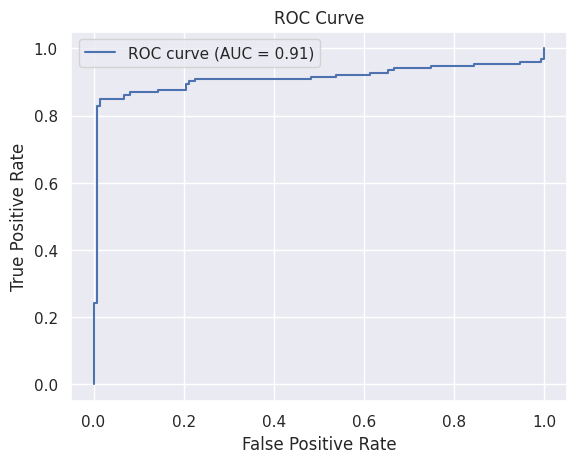


Training SVC with kernel='poly' and C=10
Accuracy: 0.90
Precision: 0.95
Recall: 0.86
F1-Score: 0.90
AUC-ROC: 0.93


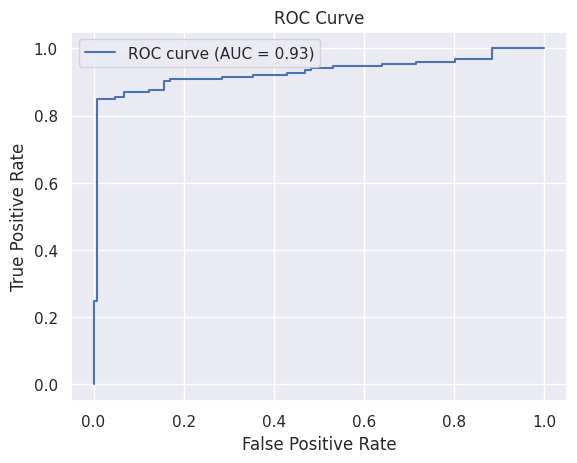

In [ ]:
import numpy as np
from sklearn.svm import SVC
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
X, y = make_classification(n_samples=1000, n_features=2, n_redundant=0, n_informative=2,
                           random_state=42, n_clusters_per_class=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_proba = model.decision_function(X_test)
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
    print(f"Precision: {precision_score(y_test, y_pred):.2f}")
    print(f"Recall: {recall_score(y_test, y_pred):.2f}")
    print(f"F1-Score: {f1_score(y_test, y_pred):.2f}")
    print(f"AUC-ROC: {roc_auc_score(y_test, y_proba):.2f}")
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label='ROC curve (AUC = {:.2f})'.format(roc_auc_score(y_test, y_proba)))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='best')
    plt.show()
kernels = ['linear', 'rbf', 'poly']
C_values = [0.1, 1, 10]
for kernel in kernels:
    for C in C_values:
        print(f"\nTraining SVC with kernel='{kernel}' and C={C}")
        model = SVC(kernel=kernel, C=C, probability=True, random_state=42)
        model.fit(X_train, y_train)
        evaluate_model(model, X_test, y_test)


#### 7. [2 Балл] Реализуйте класс KNNClassifier, который должен реализовывать классификацию путем нахождения k ближайших соседей. В методе predict_proba Вам необходимо выдавать вектор вероятностей для каждого объекта, который означает, что объект является экземпляром i-го класса с p_i вероятностью. Протестируйте Ваш класс на данных, сгенерированных выше, посмотрите на метрики (Acc, Precision, Recall, AUC-ROC, F1-Score).

Accuracy: 0.94
Precision: 0.96
Recall: 0.92
F1-Score: 0.94
AUC-ROC: 0.98


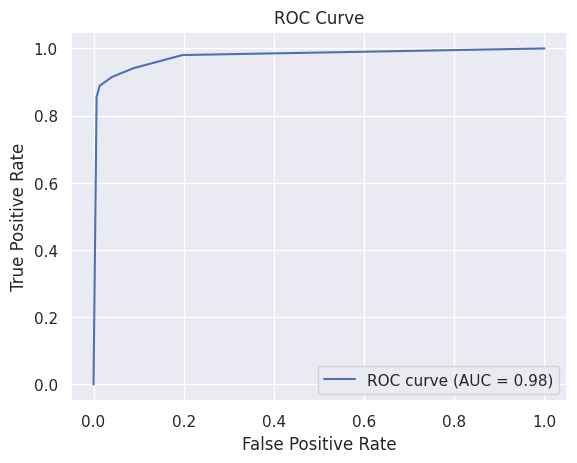

In [ ]:
import numpy as np
from collections import Counter
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
class KNNClassifier:
    def __init__(self, n_neighbors=5, metric='euclidean'):
        self.n_neighbors = n_neighbors
        self.metric = metric
    def fit(self, X, y):
        self.X_train = X
        self.y_train = y
    def _euclidean_distance(self, x1, x2):
        return np.sqrt(np.sum((x1 - x2) ** 2))
    def predict(self, X):
        predictions = [self._predict_instance(x) for x in X]
        return np.array(predictions)
    def _predict_instance(self, x):
        distances = [self._euclidean_distance(x, x_train) for x_train in self.X_train]
        k_indices = np.argsort(distances)[:self.n_neighbors]
        k_nearest_labels = [self.y_train[i] for i in k_indices]
        most_common = Counter(k_nearest_labels).most_common(1)
        return most_common[0][0]
    def predict_proba(self, X):
        probabilities = []
        for x in X:
            distances = [self._euclidean_distance(x, x_train) for x_train in self.X_train]
            k_indices = np.argsort(distances)[:self.n_neighbors]
            k_nearest_labels = [self.y_train[i] for i in k_indices]
            count = Counter(k_nearest_labels)
            prob = [count.get(label, 0) / self.n_neighbors for label in np.unique(self.y_train)]
            probabilities.append(prob)
        return np.array(probabilities)
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
X, y = make_classification(n_samples=1000, n_features=2, n_redundant=0, n_informative=2, random_state=42, n_clusters_per_class=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
model = KNNClassifier(n_neighbors=5)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print(f"Precision: {precision_score(y_test, y_pred):.2f}")
print(f"Recall: {recall_score(y_test, y_pred):.2f}")
print(f"F1-Score: {f1_score(y_test, y_pred):.2f}")
print(f"AUC-ROC: {roc_auc_score(y_test, y_proba):.2f}")
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label='ROC curve (AUC = {:.2f})'.format(roc_auc_score(y_test, y_proba)))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()

## **Практическая часть**

В этом задании мы будем работать с Датасетом Fashion Mnist. Это датасет, который представляет изображения одного канала с различными типами одежды. Вам необходимо провести полный пайплайн обучения моделей (KNN и Logreg), которые вы можете импортировать из библиотеки sklearn.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
data = pd.read_csv('/content/drive/MyDrive/train.csv')
print(data.head())

   Id  Category  Pixel000  Pixel001  Pixel002  Pixel003  Pixel004  Pixel005  \
0   0         2         0         0         0         0         0         0   
1   1         9         0         0         0         0         0         0   
2   2         6         0         0         0         0         0         0   
3   3         0         0         0         0         1         2         0   
4   4         3         0         0         0         0         0         0   

   Pixel006  Pixel007  ...  Pixel774  Pixel775  Pixel776  Pixel777  Pixel778  \
0         0         0  ...         0         0         0         0         0   
1         0         0  ...         0         0         0         0         0   
2         0         5  ...         0         0         0        30        43   
3         0         0  ...         3         0         0         0         0   
4         0         0  ...         0         0         0         0         0   

   Pixel779  Pixel780  Pixel781  Pixel782  P

#### 8. [0 Балл] Импортируйте датафрейм из csv файла. Поделите выборку следующим образом - :50000 (Train) и 50000: (Test).

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
data = pd.read_csv('/content/drive/MyDrive/train.csv')
print(data.head())
print(data.info())
train_data = data.iloc[:50000]
test_data = data.iloc[50000:]
print(f"Размер обучающей выборки: {train_data.shape}")
print(f"Размер тестовой выборки: {test_data.shape}")


   Id  Category  Pixel000  Pixel001  Pixel002  Pixel003  Pixel004  Pixel005  \
0   0         2         0         0         0         0         0         0   
1   1         9         0         0         0         0         0         0   
2   2         6         0         0         0         0         0         0   
3   3         0         0         0         0         1         2         0   
4   4         3         0         0         0         0         0         0   

   Pixel006  Pixel007  ...  Pixel774  Pixel775  Pixel776  Pixel777  Pixel778  \
0         0         0  ...         0         0         0         0         0   
1         0         0  ...         0         0         0         0         0   
2         0         5  ...         0         0         0        30        43   
3         0         0  ...         3         0         0         0         0   
4         0         0  ...         0         0         0         0         0   

   Pixel779  Pixel780  Pixel781  Pixel782  P

#### 9. [0.5 Балл] Визуализируйте некоторые из объектов датасета. В колонках отображены яркости пикселей, которые представляют из себя изображения Fashion Mnist. С помощью matplotlib визуализируйте по одному представителю каждого класса.

Имена столбцов: Index(['Id', 'Category', 'Pixel000', 'Pixel001', 'Pixel002', 'Pixel003',
       'Pixel004', 'Pixel005', 'Pixel006', 'Pixel007',
       ...
       'Pixel774', 'Pixel775', 'Pixel776', 'Pixel777', 'Pixel778', 'Pixel779',
       'Pixel780', 'Pixel781', 'Pixel782', 'Pixel783'],
      dtype='object', length=786)
Форма пиксельных данных: (60000, 784)


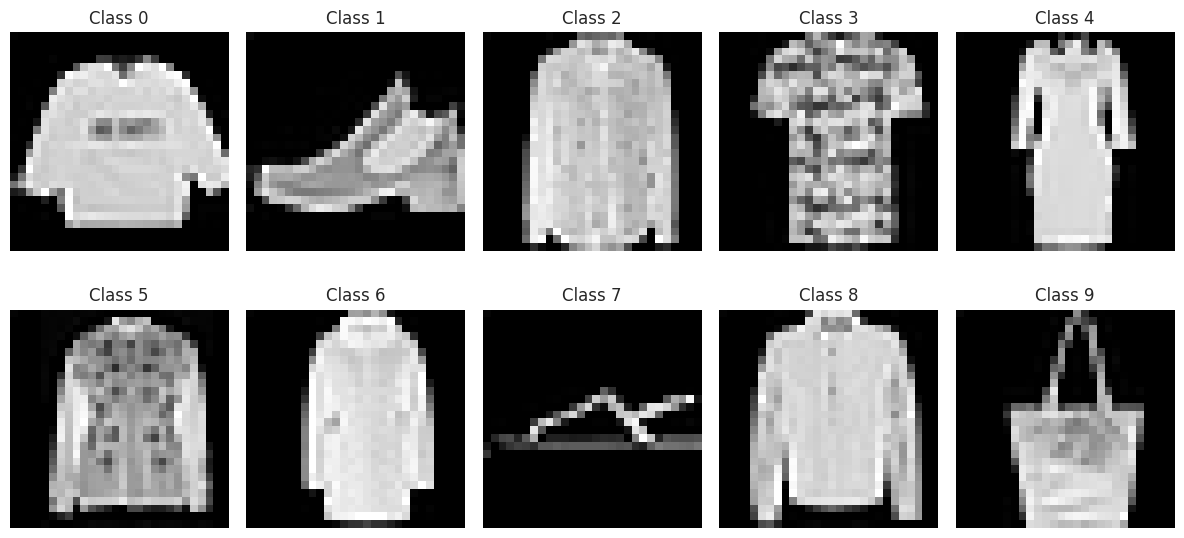

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
data = pd.read_csv('/content/drive/MyDrive/train.csv')
print(f"Имена столбцов: {data.columns}")
labels = data.iloc[:, 0]
pixels = data.iloc[:, 1:785]
print(f"Форма пиксельных данных: {pixels.shape}")
img_size = 28
num_classes = 10
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
for i in range(num_classes):
    class_index = labels[labels == i].index[0]
    img_data = pixels.iloc[class_index].values.reshape((img_size, img_size))
    ax = axes[i // 5, i % 5]
    ax.imshow(img_data, cmap='gray')
    ax.set_title(f"Class {i}")
    ax.axis('off')
plt.tight_layout()
plt.show()


#### 10. [0.5 Балл] Отнормируйте признаки в датасете, попробуйте два варианта StandartScaller и MinMaxScaller.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
data = pd.read_csv('/content/drive/MyDrive/train.csv')
labels = data.iloc[:, 0]
pixels = data.iloc[:, 1:]
standard_scaler = StandardScaler()
pixels_standard = standard_scaler.fit_transform(pixels)
data_standard = pd.DataFrame(pixels_standard, columns=pixels.columns)
data_standard.insert(0, 'label', labels)
minmax_scaler = MinMaxScaler()
pixels_minmax = minmax_scaler.fit_transform(pixels)
data_minmax = pd.DataFrame(pixels_minmax, columns=pixels.columns)
data_minmax.insert(0, 'label', labels)
print("Первые строки данных с StandardScaler:")
print(data_standard.head())
print("\nПервые строки данных с MinMaxScaler:")
print(data_minmax.head())



Первые строки данных с StandardScaler:
   label  Category  Pixel000  Pixel001  Pixel002  Pixel003  Pixel004  \
0      0 -0.870388 -0.009505 -0.022693 -0.028907 -0.041557 -0.057575   
1      1  1.566699 -0.009505 -0.022693 -0.028907 -0.041557 -0.057575   
2      2  0.522233 -0.009505 -0.022693 -0.028907 -0.041557 -0.057575   
3      3 -1.566699 -0.009505 -0.022693 -0.028907  0.366132  0.406799   
4      4 -0.522233 -0.009505 -0.022693 -0.028907 -0.041557 -0.057575   

   Pixel005  Pixel006  Pixel007  ...  Pixel774  Pixel775  Pixel776  Pixel777  \
0 -0.070503 -0.098084 -0.155981  ... -0.601712 -0.476945 -0.395154 -0.406441   
1 -0.070503 -0.098084 -0.155981  ... -0.601712 -0.476945 -0.395154 -0.406441   
2 -0.070503 -0.098084  0.198798  ... -0.601712 -0.476945 -0.395154  0.275910   
3 -0.070503 -0.098084 -0.155981  ... -0.549579 -0.476945 -0.395154 -0.406441   
4 -0.070503 -0.098084 -0.155981  ... -0.601712 -0.476945 -0.395154 -0.406441   

   Pixel778  Pixel779  Pixel780  Pixel781  Pixe

#### 10. [2 Балл] Проведите эксперименты: для моделей KNeighborsClassifier и LogisticRegression подберите гиперпараметры с помощью GridSerchCV (минимум 5 фолдов). Получите качество моделей на тестовой выборке. Основная метрика в данном задании будет accuracy. Сравните эти две модели. Какая модель показывает лучшее качество, предположите почему и напишите ответ.

**NB!**: в задании нужно подбирать несколько гиперпараметров по сетке. Какие гиперпараметры подбирать - решаете Вы сами. Обязательно обоснуйте, почему и какие параметры Вы подбираете! Например, подбор только гиперпараметра C в LogisticRegression не будет засчитываться как решение данного задания! Попытайтесь серьезно отнестись к нему, будто вы за это получите зарплату 300к.

## **Бонусы**

#### Задача 1. [1 Балл] У Вас есть датасет с 10**4 объектами. У всех объектов два признака и все они одинаковые у всех объектов. Однако, 5000 - отрицательного класса и 5000 - положительного класса. Вы запускате Логистическую регрессию для классификации на данном датасете. Что Вы получите в итоге обучения данной модели на SGD? Ответ обоснуйте.

Ответ: В описанном случае логистическая регрессия не сможет обучиться, так как все объекты имеют одинаковые признаки, а значит, модель не получит информации для разделения классов. Поскольку признаки не различаются, модель не сможет построить разделяющую границу между положительным и отрицательным классами. В результате оптимизация приведет к предсказанию одинаковой вероятности для всех объектов, независимо от их метки класса. Поскольку классы распределены равномерно (50% положительных и 50% отрицательных), модель, скорее всего, будет предсказывать вероятность, близкую к 0.5. Это означает, что модель всегда будет выдавать случайные предсказания. Качество классификации в таком случае будет низким, и модель окажется бесполезной для практического применения. Такой результат связан с отсутствием различий в признаках, которые необходимы для обучения модели.











#### Задача 2. [1 Балл] При классификации Fashion Mnist модель Логистической регрессии на обучении многоклассовой классификации методом One-VS-All у Вас получилось k классификаторов. Изобразите веса ваших полученных моделей как изображения в matplotlib. Возможно, модель выучила какие-то графические паттерны в данных? Ответ обоснуйте.

Имена столбцов: Index(['Id', 'Category', 'Pixel000', 'Pixel001', 'Pixel002', 'Pixel003',
       'Pixel004', 'Pixel005', 'Pixel006', 'Pixel007',
       ...
       'Pixel774', 'Pixel775', 'Pixel776', 'Pixel777', 'Pixel778', 'Pixel779',
       'Pixel780', 'Pixel781', 'Pixel782', 'Pixel783'],
      dtype='object', length=786)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


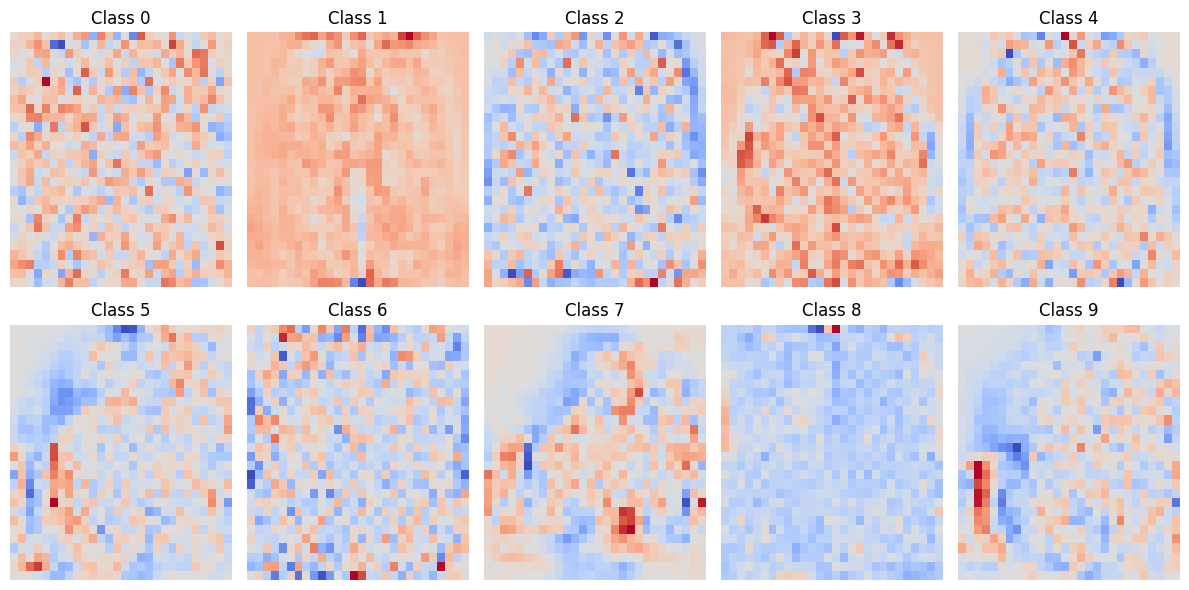

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
data = pd.read_csv('/content/drive/MyDrive/train.csv')
print("Имена столбцов:", data.columns)
y = data.iloc[:, 1].values
X = data.iloc[:, 2:].values
num_pixels = X.shape[1]
img_size = int(np.sqrt(num_pixels))
if img_size ** 2 != num_pixels:
    raise ValueError(f"Данные не соответствуют ожидаемому размеру изображения. Ожидается 28x28, получено {num_pixels} пикселей.")
scaler = MinMaxScaler()
X = scaler.fit_transform(X)
log_reg = LogisticRegression(multi_class='ovr', max_iter=1000)
log_reg.fit(X, y)
weights = log_reg.coef_
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
for i in range(10):
    weight_image = weights[i].reshape((img_size, img_size))
    ax = axes[i // 5, i % 5]
    ax.imshow(weight_image, cmap='coolwarm', aspect='auto')
    ax.set_title(f"Class {i}")
    ax.axis('off')
plt.tight_layout()
plt.show()

Пояснение: логистическая регрессия, несмотря на свою простоту,  может выучить некоторые графические паттерны.  Положительные веса будут соответствовать пикселям, которые способствуют классификации в данный класс, а отрицательные - наоборот.  

#### Задача 3. [1 Балл] В задаче классификации Fashion Mnist Вы попытались выбить какой-то accuracy. Для получения бонусного балла Вам нужно на той же самой выборке получить значение метрики accuracy > 0.87 на тесте (Тестовую выборку менять нельзя, но обучающую можно). Какими моделями и методами Вы это будете делать - на Ваше усмотрение, но **нельзя использовать никакие нейронные сети**. Необходимо получить модель машинного обучения, выполняющую эту задачу.